In [1]:
import argparse
import os
import pickle
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pyabc
#from pyabc.sampler import RedisEvalParallelSampler
import scipy.stats as stats
from fitmulticell import model as morpheus_model
from fitmulticell.sumstat import SummaryStatistics
from tqdm import tqdm
import bayesflow as bf

from load_bayesflow_model import load_model
from plotting_routines import plot_compare_summary_stats, plot_trajectory, \
    plot_autocorrelation, sampling_parameter_cis
from summary_stats import reduced_coordinates_to_sumstat, reduce_to_coordinates, \
    compute_mean_summary_stats

# get the job array id and number of processors
job_array_id = int(os.environ.get('SLURM_ARRAY_TASK_ID', 0))
n_procs = int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
print(job_array_id)
on_cluster = False
population_size = 1000
load_synthetic_data = False

if on_cluster:
    parser = argparse.ArgumentParser(description='Parse necessary arguments')
    parser.add_argument('-pt', '--port', type=str, default="50004",
                        help='Which port should be use?')
    parser.add_argument('-ip', '--ip', type=str,
                        help='Dynamically passed - BW: Login Node 3')
    args = parser.parse_args()

0


/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
if on_cluster:
    gp = '/home/jarruda_hpc/CellMigration/synth_data_params_bayesflow'
else:
    gp = os.getcwd()

par_map = {
    'gradient_strength': './CellTypes/CellType/Constant[@symbol="gradient_strength"]',
    'move.strength': './CellTypes/CellType/Constant[@symbol="move.strength"]',
    'move.duration.mean': './CellTypes/CellType/Constant[@symbol="move.duration.mean"]',
    'cell_nodes_real': './Global/Constant[@symbol="cell_nodes_real"]',
}

model_path = gp + "/cell_movement_v24.xml"  # time step is 30sec, move.dir completely normalized, init move.dir rand in all directions
# defining the summary statistics function
max_sequence_length = 120
min_sequence_length = 0
only_longest_traj_per_cell = True  # mainly to keep the data batchable
cells_in_population = 50


def make_sumstat_dict(data: Union[dict, np.ndarray]) -> dict:
    if isinstance(data, dict):
        # get key
        key = list(data.keys())[0]
        data = data[key]
    data = data[0]  # only one sample
    # compute the summary statistics
    summary_stats_dict = reduced_coordinates_to_sumstat(data)
    (ad_mean, _, msd_mean, _, ta_mean, _, vel_mean, _, wt_mean, _) = compute_mean_summary_stats([summary_stats_dict], remove_nan=False)
    cleaned_dict = {
        'ad': np.array(ad_mean).flatten(),
        'msd': np.array(msd_mean).flatten(),
        'ta': np.array(ta_mean).flatten(),
        'vel': np.array(vel_mean).flatten(),
        'wt': np.array(wt_mean).flatten()
    }
    return cleaned_dict


def prepare_sumstats(output_morpheus_model) -> dict:
    sim_coordinates = reduce_to_coordinates(output_morpheus_model, 
                          minimal_length=min_sequence_length, 
                          maximal_length=max_sequence_length,
                          only_longest_traj_per_cell=only_longest_traj_per_cell
                          )
    
    # we now do exactly the same as in the BayesFlow workflow, but here we get only one sample at a time
    data_transformed = np.ones((1, cells_in_population, max_sequence_length, 2)) * np.nan
    # each cell is of different length, each with x and y coordinates, make a tensor out of it
    n_cells_not_visible = 0
    if len(sim_coordinates) != 0:
        # some cells were visible in the simulation
        for c_id, cell_sim in enumerate(sim_coordinates):
            # pre-pad the data with zeros, but first write zeros as nans to compute the mean and std
            data_transformed[0, c_id, -len(cell_sim['x']):, 0] = cell_sim['x']
            data_transformed[0, c_id, -len(cell_sim['y']):, 1] = cell_sim['y']
    
    return {'sim': data_transformed}


sumstat = SummaryStatistics(sum_stat_calculator=prepare_sumstats)                    

if on_cluster:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # todo: remember also change tiff path in model.xml!
else:
    # define the model object
    model = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

# parameter values used to generate the synthetic data
obs_pars = {
    'gradient_strength': 100.,  # strength of the gradient of chemotaxis
    'move.strength': 10.,  # strength of directed motion
    'move.duration.mean': 0.1,  # mean of exponential distribution (seconds)
    'cell_nodes_real': 50.,  # volume of the cell (\mu m^2)
}


obs_pars_log = {key: np.log10(val) for key, val in obs_pars.items()}
limits = {'gradient_strength': (1, 10000), #(10 ** 4, 10 ** 8),
          'move.strength': (1, 100),
          'move.duration.mean': (1e-4, 30), #(math.log10((10 ** -2) * 30), math.log10((10 ** 4))), # smallest time step in simulation 5
          'cell_nodes_real': (1, 300)}
limits_log = {key: (np.log10(val[0]), np.log10(val[1])) for key, val in limits.items()}


prior = pyabc.Distribution(**{key: pyabc.RV("uniform", loc=lb, scale=ub-lb)
                              for key, (lb, ub) in limits_log.items()})
param_names = list(obs_pars.keys())
log_param_names = [f'log_{p}' for p in param_names]
print(obs_pars)

{'gradient_strength': 100.0, 'move.strength': 10.0, 'move.duration.mean': 0.1, 'cell_nodes_real': 50.0}


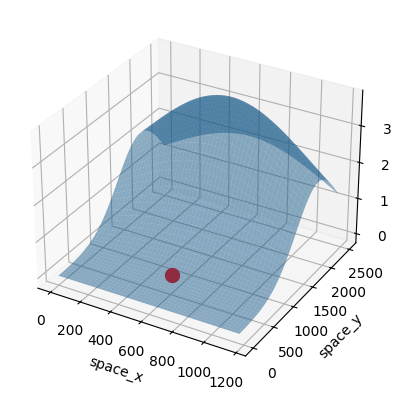

(586.5, 572.5190839694657, 1.801794707907847e-07, 3.68292430295295e-06)

In [3]:
sigma0 = 550
space_x0 = 1173/2
space_y0 = 1500/1.31/2
x0, y0 = 1173/2, (1500+1500/2+270)/1.31
u1 = lambda space_x, space_y: 7/(2*np.pi*(sigma0**2)) *np.exp(-1/2*(((space_x)-(x0))**2+ ((space_y)-(y0))**2)/(sigma0**2))

# plot the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.linspace(0, 1173 , 100)
y = np.linspace(0, 2500 , 100)
X, Y = np.meshgrid(x, y)
Z = u1(X, Y)
ax.plot_surface(X, Y, Z, alpha=0.5)
# plot start points
ax.scatter(space_x0, space_y0, u1(space_x0, space_y0), color='r', s=100)

ax.set_xlabel('space_x')
ax.set_ylabel('space_y')
plt.show()

space_x0, space_y0, u1(space_x0, space_y0), u1(x0, y0)

In [4]:
if load_synthetic_data:
    # simulate test data
    test_params = np.array(list(obs_pars_log.values()))
    if not os.path.exists(os.path.join(gp, 'test_sim.npy')):
        raise FileNotFoundError('Test data not found')
    else:
        test_sim = np.load(os.path.join(gp, 'test_sim.npy'))
        
    results_path = 'abc_results'
else:
    # load real data
    from load_data import load_real_data
    test_params = None
    real_data, real_data_full = load_real_data(data_id=1, 
                                               max_sequence_length=max_sequence_length, 
                                               cells_in_population=cells_in_population)
    test_sim = np.array([real_data[start:start+cells_in_population] for start in range(0, len(real_data), cells_in_population)])[0][np.newaxis]
    results_path = 'abc_results_real'
test_sim.shape

(1, 50, 120, 2)

In [31]:
# load bayesflow posterior samples
if load_synthetic_data:
    bayesflow_posterior_samples = np.load(f'amortizer-cell-migration-attention-8-manual/posterior_samples_synthetic.npy')
else:
    #bayesflow_posterior_samples = np.load(f'amortizer-cell-migration-attention-8-manual/posterior_samples_real.npy')
    bayesflow_posterior_samples = np.load(f'amortizer-cell-migration-ensemble/posterior_samples_real.npy')
    #bayesflow_posterior_samples = np.load(f'amortizer-cell-migration-attention-8-manual-include-real/posterior_samples_real.npy')
    #bayesflow_posterior_samples = np.load(f'amortizer-cell-migration-attention-8-manual-compare-real/posterior_samples_real.npy')
bayesflow_median = np.median(bayesflow_posterior_samples, axis=0)

In [32]:
prior_draws = np.array([list(prior.rvs().values()) for _ in range(1000)])

## ABC with Wasserstein distance

In [8]:
def obj_func_wass(sim: dict, obs: dict):
    total = 0
    for key in sim:
        x, y = np.array(sim[key]), np.array(obs[key])
        if x.size == 0:
            return np.inf
        total += stats.wasserstein_distance(x, y)
    return total

In [9]:
#redis_sampler = RedisEvalParallelSampler(host=args.ip, port=args.port,
#                                         adapt_look_ahead_proposal=False,
#                                         look_ahead=False)

abc = pyabc.ABCSMC(model, prior,
                   distance_function=obj_func_wass,
                   summary_statistics=make_sumstat_dict,
                   population_size=population_size,
                   sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=n_procs)
                   #sampler=redis_sampler
                   )

db_path = os.path.join(gp, f"{results_path}/{'synthetic' if load_synthetic_data else 'real'}_test_old_sumstats.db")
if not os.path.exists(db_path) and load_synthetic_data:  # not done for real data
    history = abc.new("sqlite:///" + db_path, make_sumstat_dict(test_sim))

    # start the abc fitting
    abc.run(min_acceptance_rate=1e-2, max_nr_populations=15)
    print('Done!')
elif load_synthetic_data:
    history = abc.load("sqlite:///" + db_path)
else:
    history = None

ABC.Sampler INFO: Parallelize sampling on 1 processes.
INFO:ABC.Sampler:Parallelize sampling on 1 processes.


In [ ]:
fig, ax = plt.subplots(1, len(param_names), tight_layout=True, figsize=(12, 4))
for i, param in enumerate(param_names):
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=limits_log[param][0],
            xmax=limits_log[param][1],
            x=param,
            xname=log_param_names[i],
            ax=ax[i],
            label=f"PDF t={t}",
        )
    ax[i].legend()
    ax[i].set_xlim((limits_log[param][0]-0.2, limits_log[param][1]+0.2))
plt.savefig(os.path.join(gp, f'{results_path}/population_kdes.png'))
plt.show()

fig, arr_ax = plt.subplots(2, 3, figsize=(12, 6), tight_layout=True)
arr_ax = arr_ax.flatten()
pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0])
pyabc.visualization.plot_walltime(history, ax=arr_ax[1], unit='h')
pyabc.visualization.plot_epsilons(history, ax=arr_ax[2])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[3])
pyabc.visualization.plot_acceptance_rates_trajectory(history, ax=arr_ax[4])
# remove last axis
arr_ax[-1].axis('off')
plt.savefig(os.path.join(gp, f'{results_path}/diagnostics.png'))
plt.show()

pyabc.visualization.plot_credible_intervals(history, levels=[0.95]);

In [ ]:
abc_df, abc_w = history.get_distribution()
abc_posterior_samples = pyabc.resample(abc_df[param_names].values, abc_w, n=1000)
abc_median = np.median(abc_posterior_samples, axis=0)

In [ ]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=abc_posterior_samples,
                                       prior_draws=prior_draws,
                                       param_names=log_param_names)
# from figure get axis
ax = fig.get_axes()
for i, a in enumerate(ax):
    # plot only on the diagonal
    if test_params is not None:
        if i == i // len(log_param_names) * (len(log_param_names)+1):
            a.axvline(test_params[i // len(log_param_names)], color='r', label='True parameter')
for i, a in enumerate(ax):
    # plot only on the diagonal
    if i == i // len(log_param_names) * (len(log_param_names)+1):
        a.axvline(abc_median[i // len(log_param_names)], color='b', label='Median parameter')
plt.savefig(os.path.join(gp, f'{results_path}/posterior_vs_prior.png'))
plt.show()

In [ ]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=bayesflow_posterior_samples,
                                       prior_draws=abc_posterior_samples[:bayesflow_posterior_samples.shape[0]],
                                       param_names=log_param_names)
# from figure get axis
ax = fig.get_axes()
for i, a in enumerate(ax):
    # plot only on the diagonal
    if test_params is not None:
        if i == i // len(log_param_names) * (len(log_param_names)+1):
            a.axvline(test_params[i // len(log_param_names)], color='r', label='True parameter')
            a.legend(loc='upper left')
plt.savefig(os.path.join(gp, f'{results_path}/posterior_abc_vs_posterior_bayesflow.png'))
plt.show()

In [ ]:
# get posterior samples and simulate
if not os.path.exists(os.path.join(gp, f'{results_path}/posterior_sim.npy')):
    # simulate the data
    sim_list = []
    for i in tqdm(range(10)):
        if i == 0:
            sim_dict = {key: p for key, p in zip(obs_pars.keys(), abc_median)}
        else:
            sim_dict = {key: p for key, p in zip(obs_pars.keys(), abc_posterior_samples[i])}
        posterior_sim = model(sim_dict)
        sim_list.append(posterior_sim['sim'])
    posterior_sim = np.concatenate(sim_list)
    np.save(os.path.join(gp, f'{results_path}/posterior_sim.npy'), posterior_sim)
else:
    #posterior_sim = np.load(os.path.join(gp, f'{results_path}/posterior_sim_prior.npy'))
    posterior_sim = np.load(os.path.join(gp, f'{results_path}/posterior_sim.npy'))

In [ ]:
# plot the summary statistics
plot_compare_summary_stats(test_sim, posterior_sim, path=f'{results_path}/Summary Stats');

In [ ]:
# plot the trajectory
plot_trajectory(test_sim[0], posterior_sim[0], path=f'{results_path}/Simulations', show_umap=True)
plot_autocorrelation(test_sim[0], posterior_sim[0], path=f'{results_path}/Autocorrelation')

## ABC with neural network summary statistics

In [33]:
if os.path.exists(os.path.join(gp, 'validation_data.pickle')):
    with open(os.path.join(gp, 'validation_data.pickle'), 'rb') as f:
        valid_data = pickle.load(f)
else:
    raise FileNotFoundError('Validation data not found')

x_mean = np.nanmean(valid_data['sim_data'], axis=(0, 1, 2))
x_std = np.nanstd(valid_data['sim_data'], axis=(0, 1, 2))
p_mean = np.mean(valid_data['prior_draws'], axis=0)
p_std = np.std(valid_data['prior_draws'], axis=0)
print('Mean and std of data:', x_mean, x_std)
print('Mean and std of parameters:', p_mean, p_std)


# compute the mean of the summary statistics
summary_stats_list_ = [reduced_coordinates_to_sumstat(t) for t in valid_data['sim_data']]
(_, ad_averg, _, MSD_averg, _, TA_averg, _, VEL_averg, _, WT_averg) = compute_mean_summary_stats(summary_stats_list_, remove_nan=False)

direct_conditions_ = np.stack([ad_averg, MSD_averg, TA_averg, VEL_averg, WT_averg]).T
# replace inf with -1
direct_conditions_[np.isinf(direct_conditions_)] = np.nan
        
summary_valid_max = np.nanmax(direct_conditions_, axis=0)
summary_valid_min = np.nanmin(direct_conditions_, axis=0)

Mean and std of data: [ 584.8564567  1218.30836285] [48.56665046 59.88427128]
Mean and std of parameters: [ 1.95494199  0.99490352 -1.43414929  1.15144457] [1.13024234 0.57772408 1.38909074 0.76196229]


In [34]:
# use trained neural net as summary statistics
def make_sumstat_dict_nn(
        data: Union[dict, np.ndarray],
) -> dict:
    if isinstance(data, dict):
        # get key
        key = list(data.keys())[0]
        data = data[key]

    trainer, map_idx_sim = load_model(
        model_id=5,
        x_mean=x_mean,
        x_std=x_std,
        p_mean=p_mean,
        p_std=p_std,
        summary_valid_max=summary_valid_max,
        summary_valid_min=summary_valid_min,
    )

    # configures the input for the network
    config_input = trainer.configurator({"sim_data": data})
    # get the summary statistics
    out_dict = {
        'summary_net': trainer.amortizer.summary_net(config_input['summary_conditions']).numpy().flatten()
    }
    # if direct conditions are available, concatenate them
    if 'direct_conditions' in config_input.keys():
        out_dict['direct_conditions'] = config_input['direct_conditions'].flatten()
        
    del trainer
    return out_dict


if on_cluster:
    # define the model object
    model_nn = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        executable="ulimit -s unlimited; /home/jarruda_hpc/CellMigration/morpheus-2.3.7",
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

    # todo: remember also change tiff path in model.xml!
else:
    # define the model object
    model_nn = morpheus_model.MorpheusModel(
        model_path, par_map=par_map, par_scale="log10",
        show_stdout=False, show_stderr=False,
        clean_simulation=True,
        raise_on_error=False, sumstat=sumstat)

In [35]:
%%time
synthetic_data_test_nn = make_sumstat_dict_nn(test_sim)
synthetic_data_test_nn

CPU times: user 499 ms, sys: 50.8 ms, total: 550 ms
Wall time: 518 ms


{'summary_net': array([ 0.13645723, -0.344517  ,  1.3001516 ,  0.91544217, -1.0929662 ,
         0.42491278, -0.50286216, -0.00428309], dtype=float32),
 'direct_conditions': array([0.21835586, 0.14175713, 0.91846925, 0.0571941 , 0.14587201],
       dtype=float32)}

In [36]:
#redis_sampler = RedisEvalParallelSampler(host=args.ip, port=args.port,
#                                         adapt_look_ahead_proposal=False,
#                                         look_ahead=False)

abc_nn = pyabc.ABCSMC(model_nn, prior, # here we use now the Euclidean distance
                      population_size=population_size,
                      summary_statistics=make_sumstat_dict_nn,
                      sampler=pyabc.sampler.MulticoreEvalParallelSampler(n_procs=n_procs)
                      #sampler=redis_sampler
                      )

db_path = os.path.join(gp, f"{results_path}/{'synthetic' if load_synthetic_data else 'real'}_test_nn_sumstats.db")

if not os.path.exists(db_path):
    history_nn = abc_nn.new("sqlite:///" + db_path, make_sumstat_dict_nn(test_sim))

    # start the abc fitting
    abc_nn.run(min_acceptance_rate=1e-2, max_nr_populations=15)
    print('Done!')
else:
    history_nn = abc_nn.load("sqlite:///" + db_path)

ABC.Sampler INFO: Parallelize sampling on 1 processes.
INFO:ABC.Sampler:Parallelize sampling on 1 processes.


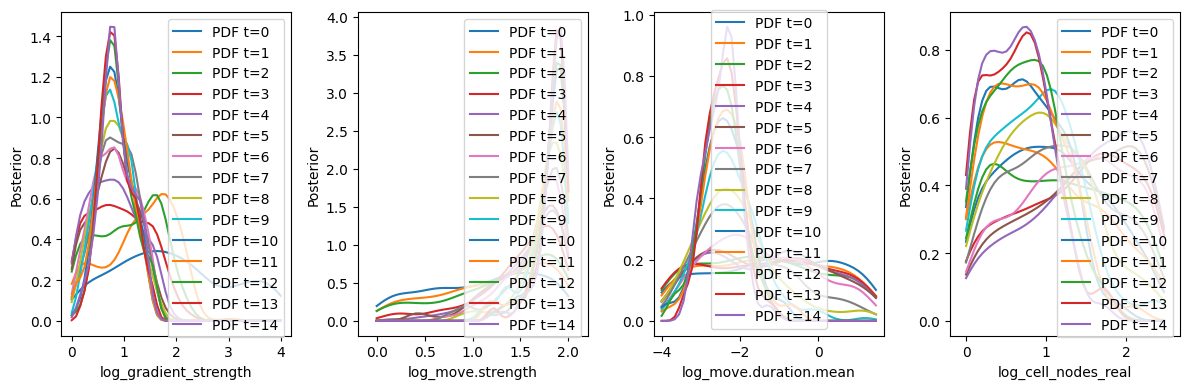

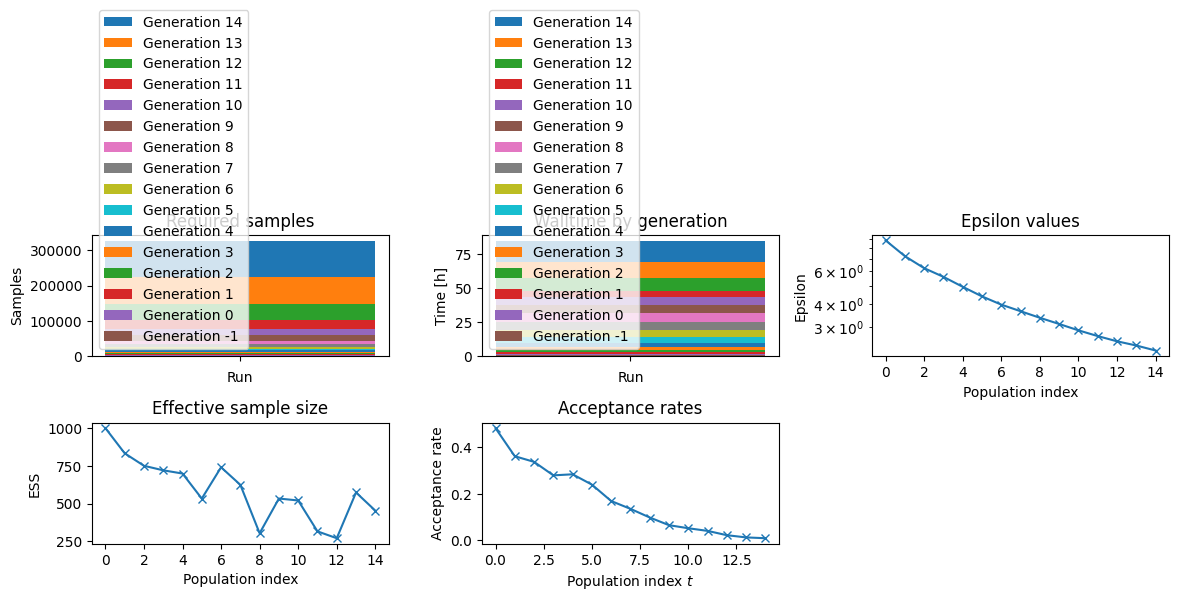

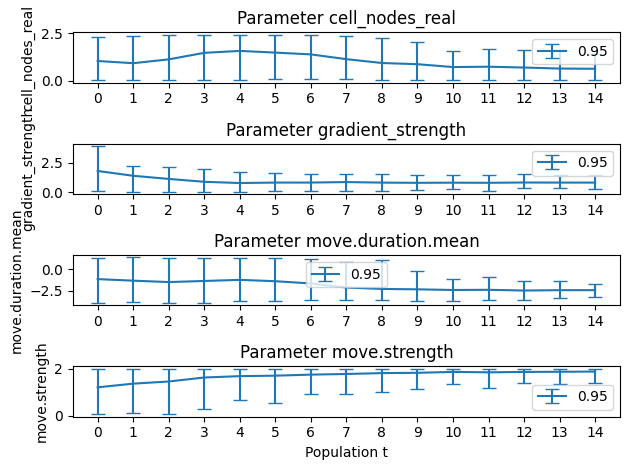

In [37]:
fig, ax = plt.subplots(1, len(param_names), tight_layout=True, figsize=(12, 4))
for i, param in enumerate(param_names):
    for t in range(history_nn.max_t + 1):
        df, w = history_nn.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(
            df,
            w,
            xmin=limits_log[param][0],
            xmax=limits_log[param][1],
            x=param,
            xname=log_param_names[i],
            ax=ax[i],
            label=f"PDF t={t}",
        )
    ax[i].legend()
    ax[i].set_xlim((limits_log[param][0]-0.2, limits_log[param][1]+0.2))
plt.savefig(os.path.join(gp, f'{results_path}/population_kdes_nn.png'))
plt.show()

fig, arr_ax = plt.subplots(2, 3, figsize=(12, 6), tight_layout=True)
arr_ax = arr_ax.flatten()
pyabc.visualization.plot_sample_numbers(history_nn, ax=arr_ax[0])
pyabc.visualization.plot_walltime(history_nn, ax=arr_ax[1], unit='h')
pyabc.visualization.plot_epsilons(history_nn, ax=arr_ax[2])
pyabc.visualization.plot_effective_sample_sizes(history_nn, ax=arr_ax[3])
pyabc.visualization.plot_acceptance_rates_trajectory(history_nn, ax=arr_ax[4])
# remove last axis
arr_ax[-1].axis('off')
plt.savefig(os.path.join(gp, f'{results_path}/diagnostics_nn.png'))
plt.show()

pyabc.visualization.plot_credible_intervals(history_nn, levels=[0.95]);

In [38]:
abc_df, abc_w = history_nn.get_distribution()
abc_posterior_samples_nn = pyabc.resample(abc_df[param_names].values, abc_w, n=1000)
abc_nn_median = np.median(abc_posterior_samples_nn, axis=0)

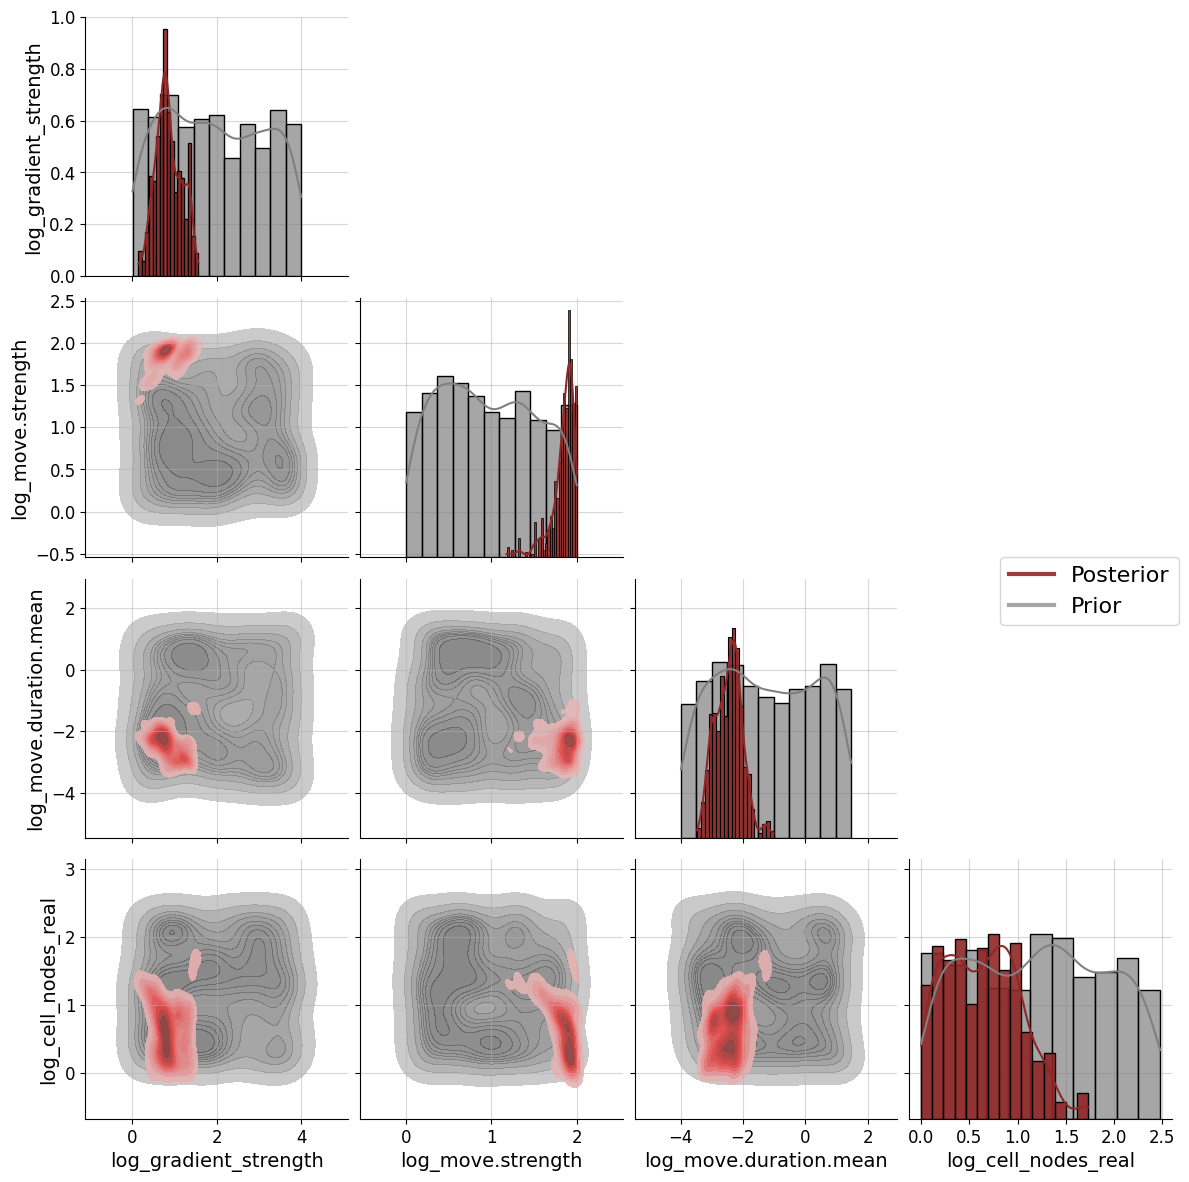

In [39]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=abc_posterior_samples_nn,
                                       prior_draws=prior_draws,
                                       param_names=log_param_names)
# from figure get axis
ax = fig.get_axes()
for i, a in enumerate(ax):
    # plot only on the diagonal
    if test_params is not None:
        if i == i // len(log_param_names) * (len(log_param_names)+1):
            a.axvline(test_params[i // len(log_param_names)], color='r', label='True parameter')
plt.savefig(os.path.join(gp, f'{results_path}/posterior_vs_prior_nn_summary.png'))
plt.show()

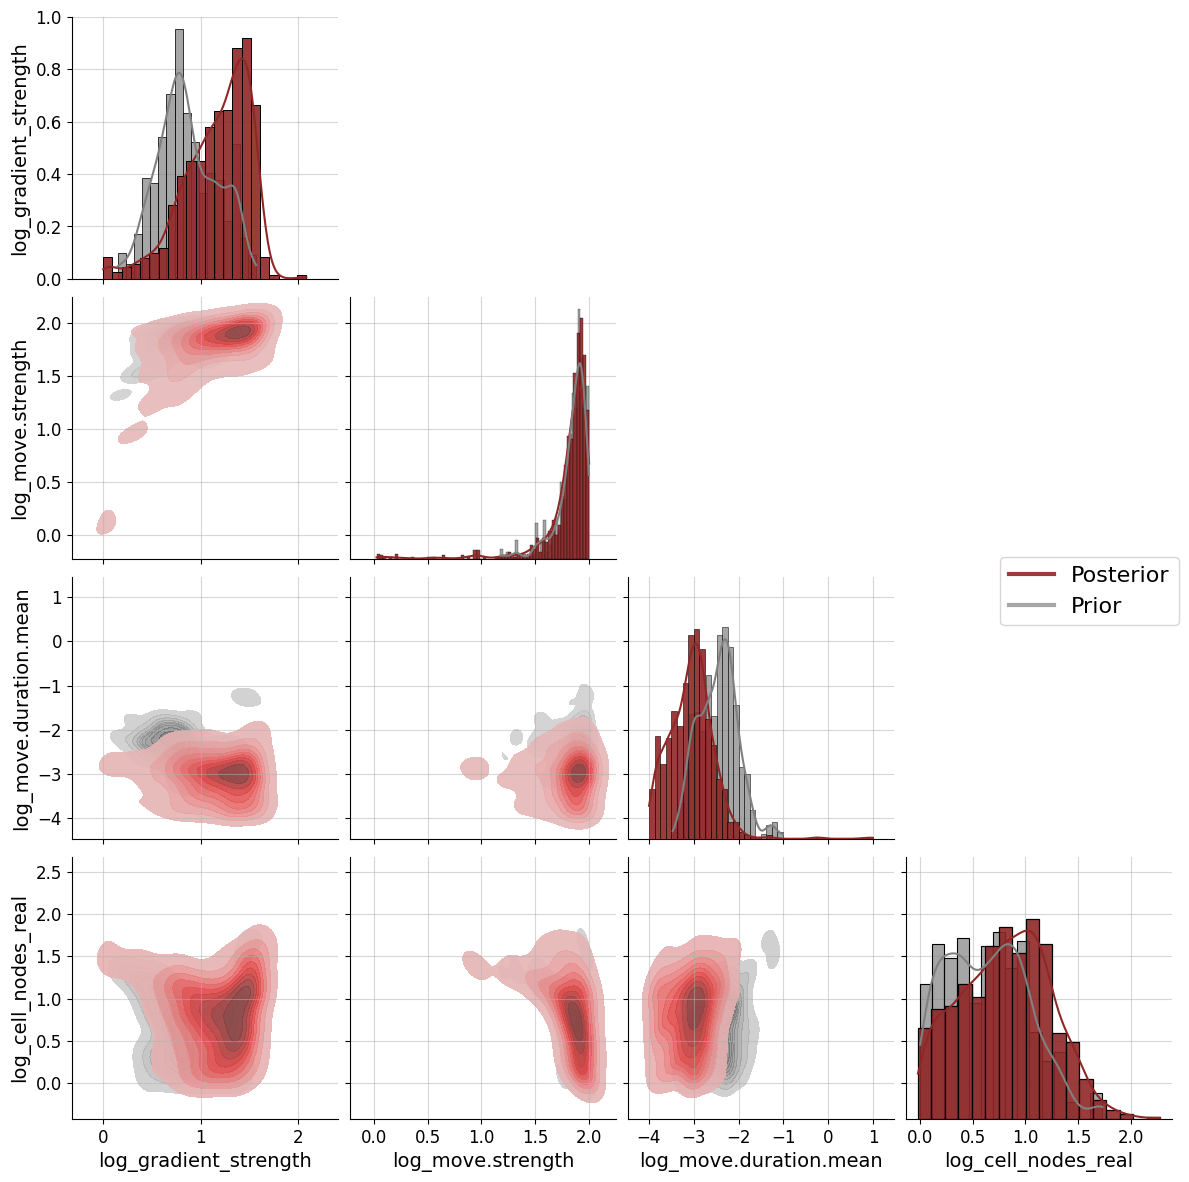

In [40]:
fig = bf.diagnostics.plot_posterior_2d(posterior_draws=bayesflow_posterior_samples,
                                       prior_draws=abc_posterior_samples_nn[:bayesflow_posterior_samples.shape[0]],
                                       param_names=log_param_names)
# from figure get axis
ax = fig.get_axes()
for i, a in enumerate(ax):
    # plot only on the diagonal
    if test_params is not None:
        if i == i // len(log_param_names) * (len(log_param_names)+1):
            a.axvline(test_params[i // len(log_param_names)], color='r', label='True parameter')
            a.legend(loc='upper left')
plt.savefig(os.path.join(gp, f'{results_path}/posterior_abc_nn_vs_posterior_bayesflow.png'))
plt.show()

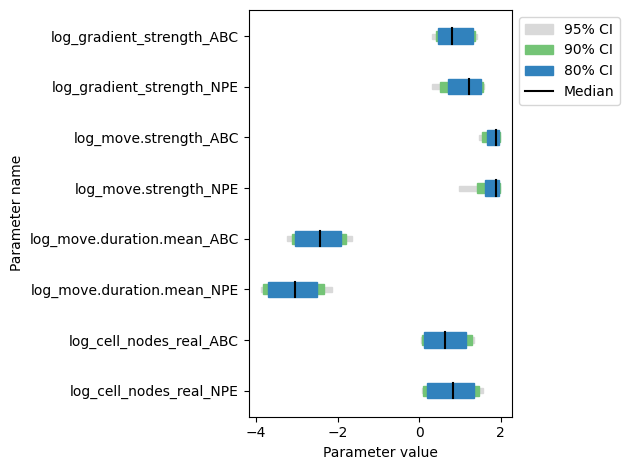

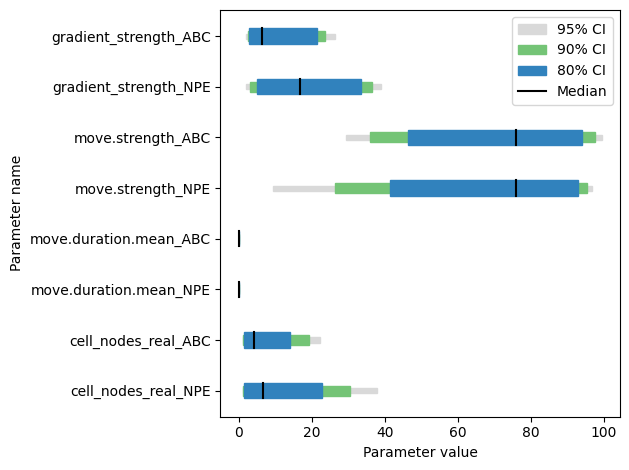

In [41]:
ordering = [0,4,1,5,2,6,3,7]
all_params = np.concatenate((abc_posterior_samples_nn, bayesflow_posterior_samples), axis=-1)
#all_params = np.power(10, all_params)

ax = sampling_parameter_cis(
    all_params[:, ordering],
    param_names=np.array(
        [f'{n}_ABC' for n in log_param_names] +  [f'{n}_NPE' for n in log_param_names]
    )[ordering],
    alpha=[95, 90 , 80],
)
plt.savefig(os.path.join(gp, f'{results_path}/posterior_credible_intervals.png'))
plt.show()

all_params = np.power(10, all_params)
ax = sampling_parameter_cis(
    all_params[:, ordering],
    param_names=np.array(
        [f'{n}_ABC' for n in param_names] +  [f'{n}_NPE' for n in param_names]
    )[ordering],
    alpha=[95, 90 , 80],
)
plt.savefig(os.path.join(gp, f'{results_path}/posterior_credible_intervals_log.png'))
plt.show()

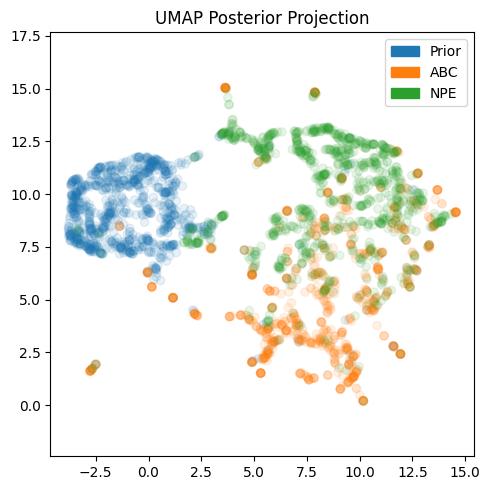

In [42]:
all_samples = np.concatenate([
    prior_draws[:bayesflow_posterior_samples.shape[0]],
    abc_posterior_samples_nn[:bayesflow_posterior_samples.shape[0]],
    bayesflow_posterior_samples
])
color_code = np.concatenate([
    np.zeros(prior_draws[:bayesflow_posterior_samples.shape[0]].shape[0]), 
    np.ones(abc_posterior_samples_nn[:bayesflow_posterior_samples.shape[0]].shape[0]),
    np.ones(bayesflow_posterior_samples.shape[0])*2
])

# make a umap plot
import umap
from matplotlib.patches import Patch

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
reducer = umap.UMAP(random_state=42, n_jobs=1)
embedding = reducer.fit_transform(all_samples)

plt.figure(tight_layout=True, figsize=(5, 5))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[colors[int(i)] for i in color_code],
    alpha=0.1,
)
plt.gca().set_aspect('equal', 'datalim')
patches = [Patch(color=colors[i], label=f'{["Prior", "ABC", "NPE"][i]}') for i in range(len(colors))]
plt.legend(handles=patches)
plt.title('UMAP Posterior Projection')
plt.show()

In [43]:
# get posterior samples and simulate
if not os.path.exists(os.path.join(gp, f'{results_path}/posterior_sim_nn.npy')):
    # simulate the data
    sim_list = []
    for i in tqdm(range(10)):
        if i == 0:
            sim_dict = {key: p for key, p in zip(obs_pars.keys(), abc_nn_median)}
        else:
            sim_dict = {key: p for key, p in zip(obs_pars.keys(), abc_posterior_samples_nn[i])}
        posterior_sim = model_nn(sim_dict)
        sim_list.append(posterior_sim['sim'])
    posterior_sim_nn = np.concatenate(sim_list)
    np.save(os.path.join(gp, f'{results_path}/posterior_sim_nn.npy'), posterior_sim_nn)
else:
    posterior_sim_nn = np.load(os.path.join(gp, f'{results_path}/posterior_sim_nn.npy'))

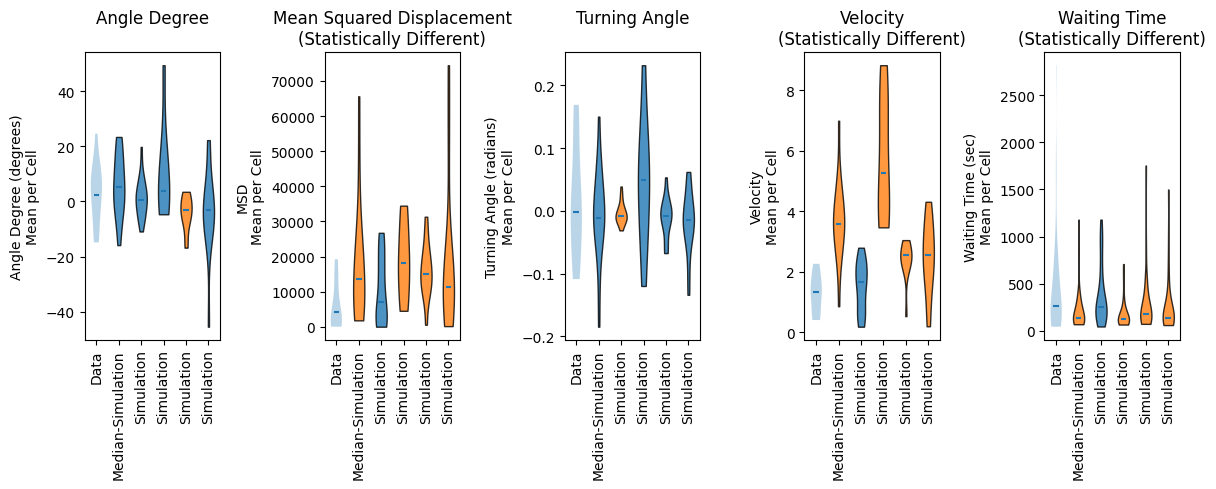

Wasserstein distance: 11826.766250666808


In [44]:
# plot the summary statistics
plot_compare_summary_stats(test_sim, posterior_sim_nn, path=f'{results_path}/Summary Stats NN');

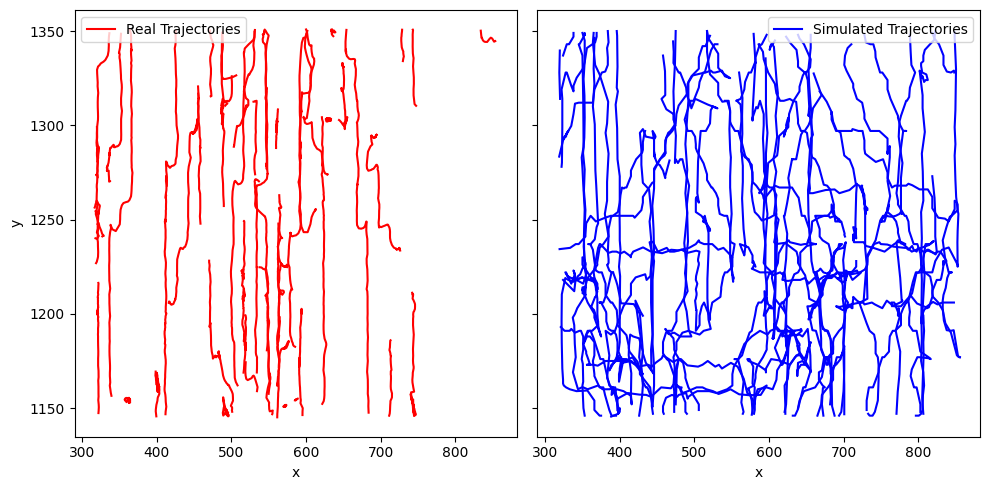

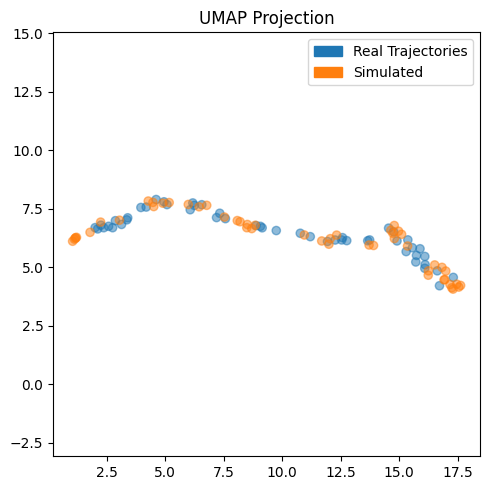

/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/jonas.arruda/miniconda/envs/CellMigration/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


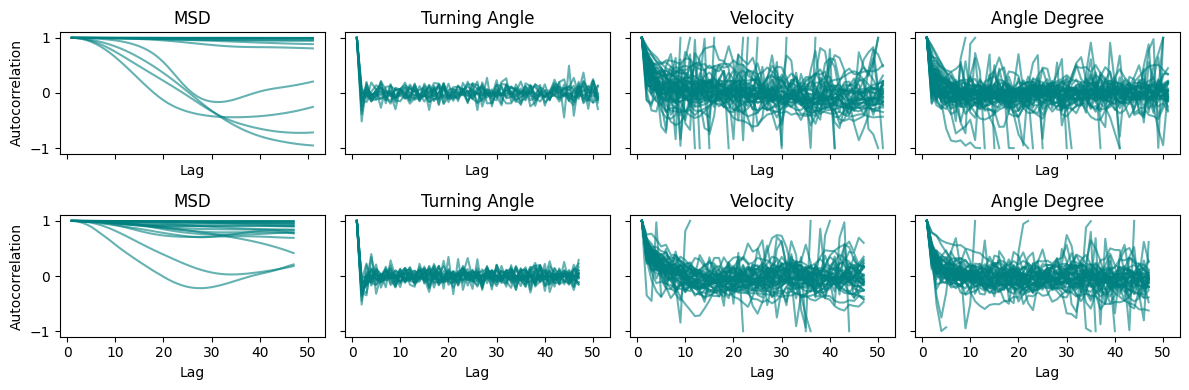

In [45]:
# plot the trajectory
plot_trajectory(test_sim[0], posterior_sim_nn[0], 
                path=f'{results_path}/Simulations NN', 
                label_true=None if load_synthetic_data else 'Real Trajectories', two_plots=True, show_umap=True)
plot_autocorrelation(test_sim[0], posterior_sim_nn[0], path=f'{results_path}/Autocorrelation NN')

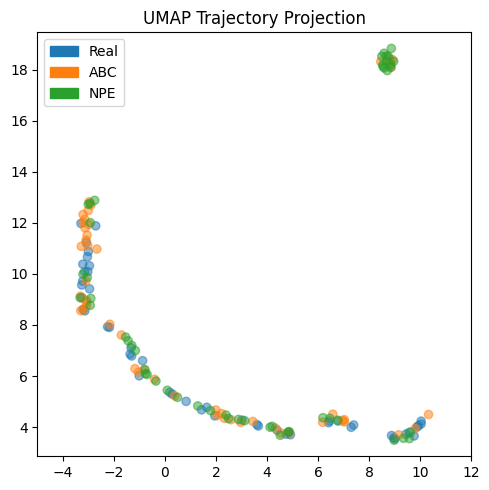

In [54]:
posterior_sim_real_bayes_flow = np.load(f'amortizer-cell-migration-ensemble/posterior_sim_real_1.npy')
all_trajec = np.concatenate([
    test_sim[0],
    posterior_sim_nn[0],
    posterior_sim_real_bayes_flow[0],
])
all_trajec = np.concatenate([all_trajec[..., 0], all_trajec[..., 1]], axis=1)
all_trajec[np.isnan(all_trajec)] = -1

color_code = np.concatenate([
    np.zeros(test_sim[0].shape[0]), 
    np.ones(posterior_sim_nn[0].shape[0]),
    np.ones(posterior_sim_real_bayes_flow[0].shape[0])*2
])

# make a umap plot
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
reducer = umap.UMAP(random_state=0, n_jobs=1)
embedding = reducer.fit_transform(all_trajec)

plt.figure(tight_layout=True, figsize=(5, 5))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[colors[int(i)] for i in color_code],
    alpha=0.5,
)
plt.gca().set_aspect('equal', 'datalim')
patches = [Patch(color=colors[i], label=f'{["Real", "ABC", "NPE"][i]}') for i in range(len(colors))]
plt.legend(handles=patches)
plt.title('UMAP Trajectory Projection')
plt.show()

In [47]:
def get_summary_vector(data):
    data = make_sumstat_dict_nn(data)
    data = np.concatenate([data['summary_net'], data['direct_conditions']])[np.newaxis]
    return data

In [55]:
d1 = get_summary_vector(test_sim)
d2 = np.concatenate([get_summary_vector(sim[np.newaxis]) for sim in posterior_sim_nn])
d3 = np.concatenate([get_summary_vector(sim[np.newaxis]) for sim in posterior_sim_real_bayes_flow])
all_latent_trajec = np.concatenate([d1, d2, d3])

color_code = np.concatenate([
    np.zeros(d1.shape[0]), 
    np.ones(d2.shape[0]),
    np.ones(d3.shape[0])*2
])

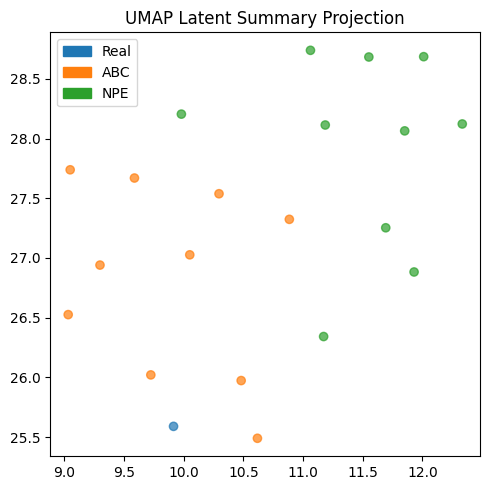

In [56]:
# make a umap plot
reducer = umap.UMAP(random_state=42, n_jobs=1, metric='manhattan')
embedding = reducer.fit_transform(all_latent_trajec)

plt.figure(tight_layout=True, figsize=(5, 5))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=[colors[int(i)] for i in color_code],
    alpha=0.7,
)
plt.gca().set_aspect('equal', 'datalim')
patches = [Patch(color=colors[i], label=f'{["Real", "ABC", "NPE"][i]}') for i in range(len(colors))]
plt.legend(handles=patches)
plt.title('UMAP Latent Summary Projection')
plt.show()

In [61]:
def compute_latent_error(true, pred, p=1):  # p=1 is default in pyABC
    true = make_sumstat_dict_nn(true)
    true = np.concatenate([true['summary_net'], true['direct_conditions']])
    if pred.shape[0] == 1:
        pred = make_sumstat_dict_nn(pred)
    else:
        print('only computing error for first sample')
        pred = make_sumstat_dict_nn(pred[0][np.newaxis])    
    pred = np.concatenate([pred['summary_net'], pred['direct_conditions']])
    
    distance = np.abs(true - pred)
    print(distance)
    distance = (distance**p).sum() ** (1 / p)
    return distance

In [62]:
compute_latent_error(test_sim, posterior_sim_nn), compute_latent_error(test_sim, posterior_sim_real_bayes_flow)

only computing error for first sample
[0.41529825 0.17964888 0.19431734 0.16203696 0.08829594 0.49110422
 0.80185044 0.02901885 0.14613482 0.28885943 0.23027599 0.11559781
 0.083191  ]
only computing error for first sample
[0.21064489 0.5655865  0.50667024 0.5515566  0.6397571  1.1000215
 1.4575315  0.4517968  0.14422688 0.21374366 0.2669428  0.0427435
 0.03740051]


(3.2256298065185547, 6.188622951507568)

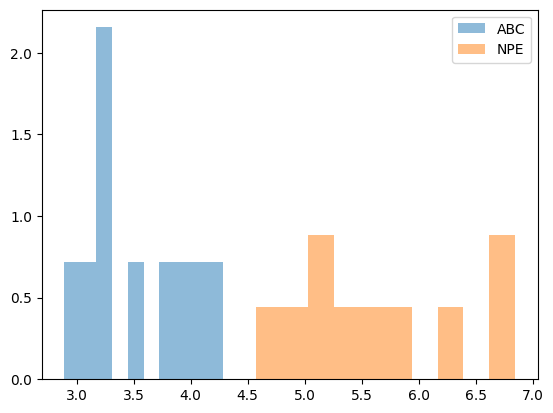

In [59]:
plt.hist([compute_latent_error(test_sim, posterior_sim_nn[i][np.newaxis]) 
          for i in range(posterior_sim_nn.shape[0])],
         alpha=0.5, label='ABC', bins=10, density=True)
plt.hist([compute_latent_error(test_sim, posterior_sim_real_bayes_flow[i][np.newaxis]) 
          for i in range(posterior_sim_real_bayes_flow.shape[0])],
         alpha=0.5, label='NPE', bins=10, density=True)

plt.legend()
plt.show()

In [60]:
compute_latent_error(posterior_sim_nn[0][np.newaxis], posterior_sim_real_bayes_flow[0][np.newaxis])

3.7636361122131348